In [1]:
import networkx as nx
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

cities = dict(
    Arad=dict(Zerind=75, Sibiu=140, Timisoara=118),
    Bucharest=dict(Urziceni=85, Pitesti=101, Giurgiu=90, Fagaras=211),
    Craiova=dict(Drobeta=120, Rimnicu=146, Pitesti=138),
    Drobeta=dict(Mehadia=75),
    Eforie=dict(Hirsova=86),
    Fagaras=dict(Sibiu=99),
    Hirsova=dict(Urziceni=98),
    Iasi=dict(Vaslui=92, Neamt=87),
    Lugoj=dict(Timisoara=111, Mehadia=70),
    Oradea=dict(Zerind=71, Sibiu=151),
    Pitesti=dict(Rimnicu=97),
    Rimnicu=dict(Sibiu=80),
    Urziceni=dict(Vaslui=142));

coordinates = dict(
    Arad=(91, 492), Bucharest=(400, 327), Craiova=(253, 288),
    Drobeta=(165, 299), Eforie=(562, 293), Fagaras=(305, 449),
    Giurgiu=(375, 270), Hirsova=(534, 350), Iasi=(473, 506),
    Lugoj=(165, 379), Mehadia=(168, 339), Neamt=(406, 537),
    Oradea=(131, 571), Pitesti=(320, 368), Rimnicu=(233, 410),
    Sibiu=(207, 457), Timisoara=(94, 410), Urziceni=(456, 350),
    Vaslui=(509, 444), Zerind=(108, 531));


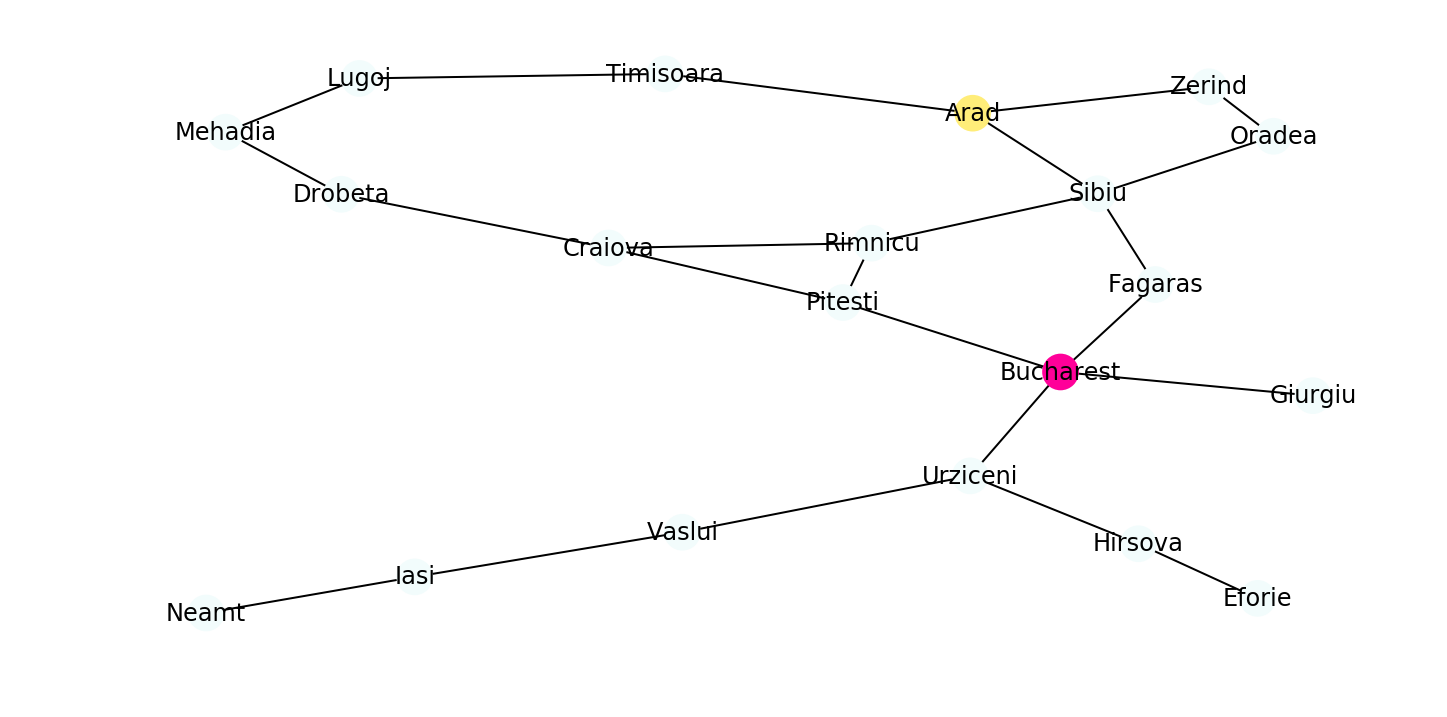

In [2]:
G = nx.Graph()

root = None;
goal = None;
cmap = {'neutral':'#f2fcfc', 'root':'#FFED79', 'goal':'#FF0099'}

def setRoot(label):
    color_map[list(G).index(label)] = cmap['root'];
    return G.node[label];

def setGoal(label):
    G.node[label]['isGoal'] = True;
    color_map[list(G).index(label)]= cmap['goal'];
    return G.node[label];

# one color for each node
color_map = [];

for nodeName, coordin in coordinates.items():
    G.add_node(nodeName, label=nodeName, coord=coordin, isGoal=False)
    color_map.append(cmap['neutral']);
for k,v in cities.items():
    for k1,v1 in v.items():
        G.add_edge(k,k1,cost=v1);
        
root = setRoot('Arad');
goal = setGoal('Bucharest');

plt.figure(figsize=(12,6))
nx.draw_networkx(G, node_size=300, node_color = color_map, with_labels = True);
plt.axis('off');


In [3]:
class node_wrapper:
    
    def __init__(self, node, g=None, parent=None):
        self.node = node;
        self.parent = parent;
        self.g = g

In [4]:
# get childs of a node, if the node hasn't a parent childs == neighbours
def getChilds(n):
    childs = []
    label = n.node['label']
    for k,v in G.adj[label].items():
        if n.parent == None or k != n.parent.node['label']:
            node_w = node_wrapper(G.node[k])
            childs.append(node_w)
    return childs

# test
#p = node_wrapper(G.node['Sibiu'])
#n = node_wrapper(root,p)
#print(getChilds(n))

In [5]:
def pathFromRoot(node):
    path = ""
    if node.parent != None:
        path = pathFromRoot(node.parent);
    return path + " -> " + node.node['label'];

# test
#n = root
#p = node_wrapper(goal)
#x = node_wrapper(n,p)
#pathFromRoot(x)

In [6]:
# breadth first search

import time
class breadth_first:
    
    def __init__(self, graph, root, goal):
        
        self.open=[];
        self.close=[];
        
        self.open.append(node_wrapper(root))
        
        while (True):

            if self.open:
                # pop first from open and push it in closed
                n = self.open.pop(0);
                print('extracted: ' + n.node['label']);
                
                if n.parent != None:
                    print('(parent: '+n.parent.node['label']+')')
                    
                self.close.append(n);
            else:
                print('search failed');
                return;

            childs = getChilds(n)
            print('childs: ')

            for child in childs:
                
                print('> ' + child.node['label'])
                if child.parent != None:
                    print('>> (parent: '+child.parent.node['label']+')')
                
                x = node_wrapper(child.node,parent=n)
                self.open.append(x);
                
                if child.node['isGoal']:
                    print('\n### Goal found ###');
                    print(pathFromRoot(x));
                    return;

In [7]:
breadth_first(G,root,goal)

extracted: Arad
childs: 
> Zerind
> Sibiu
> Timisoara
extracted: Zerind
(parent: Arad)
childs: 
> Oradea
extracted: Sibiu
(parent: Arad)
childs: 
> Fagaras
> Oradea
> Rimnicu
extracted: Timisoara
(parent: Arad)
childs: 
> Lugoj
extracted: Oradea
(parent: Zerind)
childs: 
> Sibiu
extracted: Fagaras
(parent: Sibiu)
childs: 
> Bucharest

### Goal found ###
 -> Arad -> Sibiu -> Fagaras -> Bucharest


In [8]:
def find_node(node_name, l):
    j = 0
    for i in l:
        if i.node['label'] == node_name:
            return j
        j += 1
    return False

In [9]:
# Uniform cost search (Dijkstra)
        
class uniform_cost:
    
    def __init__(self, graph, root, goal):
        
        self.open=[]
        self.closed=[]
        
        self.open.append(node_wrapper(root, g=0))
        
        while (True):

            if self.open:
                # sort open list by path cost
                self.open.sort(key=lambda x:x.g)
                # pop node with minimum path from open and push it in closed
                n = self.open.pop(0)
                print('extracted: ' + n.node['label'])
                
                if n.parent != None:
                    print('(parent: '+n.parent.node['label']+')')
                    
                self.closed.append(n)
            else:
                print('search failed');
                return;

            childs = getChilds(n)
            print('childs: ')

            for child in childs:
                
                print('> ' + child.node['label'])
                if child.parent != None:
                    print('>> (parent: '+child.parent.node['label']+')')
                
                # cost from parent to child
                Cnm = G[child.node['label']][n.node['label']]['cost']
                
                # child is in open: update cost and set parent
                index = find_node(child.node['label'],self.open)
                if index != False:
                    # update node if cost from this path is cheaper than previous cost
                    if (Cnm + n.g) < self.open[index].g:
                        self.open[index] += Cnm + n.g
                        self.open[index].parent = n
                # child is in closed: has already minimum costs and cannot be reopened
                else:
                    index = find_node(child.node['label'],self.closed)
                    if index != False:
                        pass
                    # child is new: put in open and initialize g
                    else:
                        x = node_wrapper(child.node, g=Cnm+n.g, parent=n)
                        self.open.append(x)
                
                if child.node['isGoal']:
                    print('\n### Goal found ###')
                    print(pathFromRoot(x))
                    return;
                
                
uniform_cost(G,root,goal)

extracted: Arad
childs: 
> Zerind
> Sibiu
> Timisoara
extracted: Zerind
(parent: Arad)
childs: 
> Oradea
extracted: Timisoara
(parent: Arad)
childs: 
> Lugoj
extracted: Sibiu
(parent: Arad)
childs: 
> Fagaras
> Oradea
> Rimnicu
extracted: Oradea
(parent: Zerind)
childs: 
> Sibiu
extracted: Rimnicu
(parent: Sibiu)
childs: 
> Craiova
> Pitesti
extracted: Lugoj
(parent: Timisoara)
childs: 
> Mehadia
extracted: Fagaras
(parent: Sibiu)
childs: 
> Bucharest

### Goal found ###
 -> Arad -> Sibiu -> Fagaras -> Bucharest


In [10]:
# Depth first search

class depht_first:
    
    def __init__(self, graph, root, goal, maxlevel = None):
        
        self.open=[]
        self.closed=[]
        self.maxlevel = maxlevel
        self.cur = None
        
        # start search from the root
        r = node_wrapper(root)
        result = self.backtrack(r,0,[root])
        if result:
            print ('\n### Goal found ###')
            print(pathFromRoot(self.cur))
        else:
            print ('path not found')
            
    def backtrack(self, state, level, curpath):
        
        self.cur = state
        
        print ('extracted: ' + self.cur.node['label'])
        if self.cur.parent != None:
                    print('(parent: '+self.cur.parent.node['label']+')')
                
        # return if the node is a goal
        if self.cur.node['isGoal']:
            return True
        
        # check max level
        if level == self.maxlevel:
            print('max level reached')
            return False
        
        childs = getChilds(self.cur)
        if len(childs) == 0:
            # deadend
            return
        
        res = False
        
        for child in childs:
            print(' > ' + child.node['label'] )           
            if child.node in curpath:
                continue
            child.parent = self.cur
            curpath.append(child.node)
            res = self.backtrack(child, level+1, curpath)
            if res:
                break
            else:
                curpath.remove(child.node)
            
        return res
        
depht_first(G,root,goal)

extracted: Arad
 > Zerind
extracted: Zerind
(parent: Arad)
 > Oradea
extracted: Oradea
(parent: Zerind)
 > Sibiu
extracted: Sibiu
(parent: Oradea)
 > Arad
 > Fagaras
extracted: Fagaras
(parent: Sibiu)
 > Bucharest
extracted: Bucharest
(parent: Fagaras)

### Goal found ###
 -> Arad -> Zerind -> Oradea -> Sibiu -> Fagaras -> Bucharest
